In [1]:
using QuadraticTeamDecisionSolver, Distributions, Statistics, LinearAlgebra, Plots, LaTeXStrings
gr()

Plots.GRBackend()

In [2]:
#replace with desired directory
saveTo = "/home/santos/Desktop/thesis-plots";
l=1.5;
dpi=1000;

### problem specification


In [27]:
N = K = 2;
L = 1
P = 0.5; 
omega = 1.1;
σₕ = 1.0;
σₙ = σₕ/10;
ϵ = 0.4;


In [28]:
p = QuadTeamProblem(N, N * K * L * ones(Int64, N), L*ones(Int64, N), ComplexF64);
t = teamMMSEproblem(
	P,
	N,
	L,
	K,
	σₕ * ones(Float64, N),
	σₙ * ones(Float64, N),
	ϵ * ones(Float64, N)
);


In [29]:
p = checkProblem(p)

QuadTeamProblem{ComplexF64}(2, [4, 4], [1, 1], ComplexF64)

### Data Sets

In [46]:
m_train = 200;
m_test = 400;
iters = 20;
Y_train, Q_train, R_train = generateTeamMMSEsamples(t, m_train);
Y_test, Q_test, R_test = generateTeamMMSEsamples(t, m_test);

### Kernel and Solver Specifications

In [47]:
h₁ = 1.0;
h₂ = 1.0;
λ₁ = σₙ^2; #noise variance
λ₂ = σₙ^2;

k₁(x,y) = exponentialKernel(x,y,h=h₁);
k₂(x,y) = exponentialKernel(x,y,h=h₂);

kernels = [k₁, k₂];
λ = [λ₁, λ₂];

In [48]:
γj = jacobiSolver(p, m_train, Y_train, Q_train, R_train, kernels, λ, iterations=iters);

In [49]:
γg = gaussSeidelSolver(p, m_train, Y_train, Q_train, R_train, kernels, λ, iterations=iters);

In [50]:
γsor = SORSolver(p, m_train, Y_train, Q_train, R_train, kernels, λ, iterations=iters, omega=omega);

In [51]:
resJacobi = [residual(m_train, p, kernels, [γj[1][k], γj[2][k]], Y_train, Q_train, R_train, λ) for k in 1:iters];


In [52]:
resGaussSeidel = [residual(m_train, p, kernels, [γg[1][k], γg[2][k]], Y_train, Q_train, R_train, λ) for k in 1:iters];


In [53]:
resSOR = [residual(m_train, p, kernels, [γsor[1][k], γsor[2][k]], Y_train, Q_train, R_train, λ) for k in 1:iters];

In [54]:
resJ  = [[x -> kernelFunction(kernels[i], resJacobi[l][i], Y_train[i], x) for i in 1:p.N] for l in 1:iters];
resG  = [[x -> kernelFunction(kernels[i], resGaussSeidel[l][i], Y_train[i], x) for i in 1:p.N] for l in 1:iters];
resS  = [[x -> kernelFunction(kernels[i], resSOR[l][i], Y_train[i], x) for i in 1:p.N] for l in 1:iters];

In [55]:
perfJ = [GammaNorm(resJ[l], Y_test, p=2) for l in 1:iters];
perfG = [GammaNorm(resG[l], Y_test, p=2) for l in 1:iters];
perfSOR = [GammaNorm(resS[l], Y_test, p=2) for l in 1:iters];

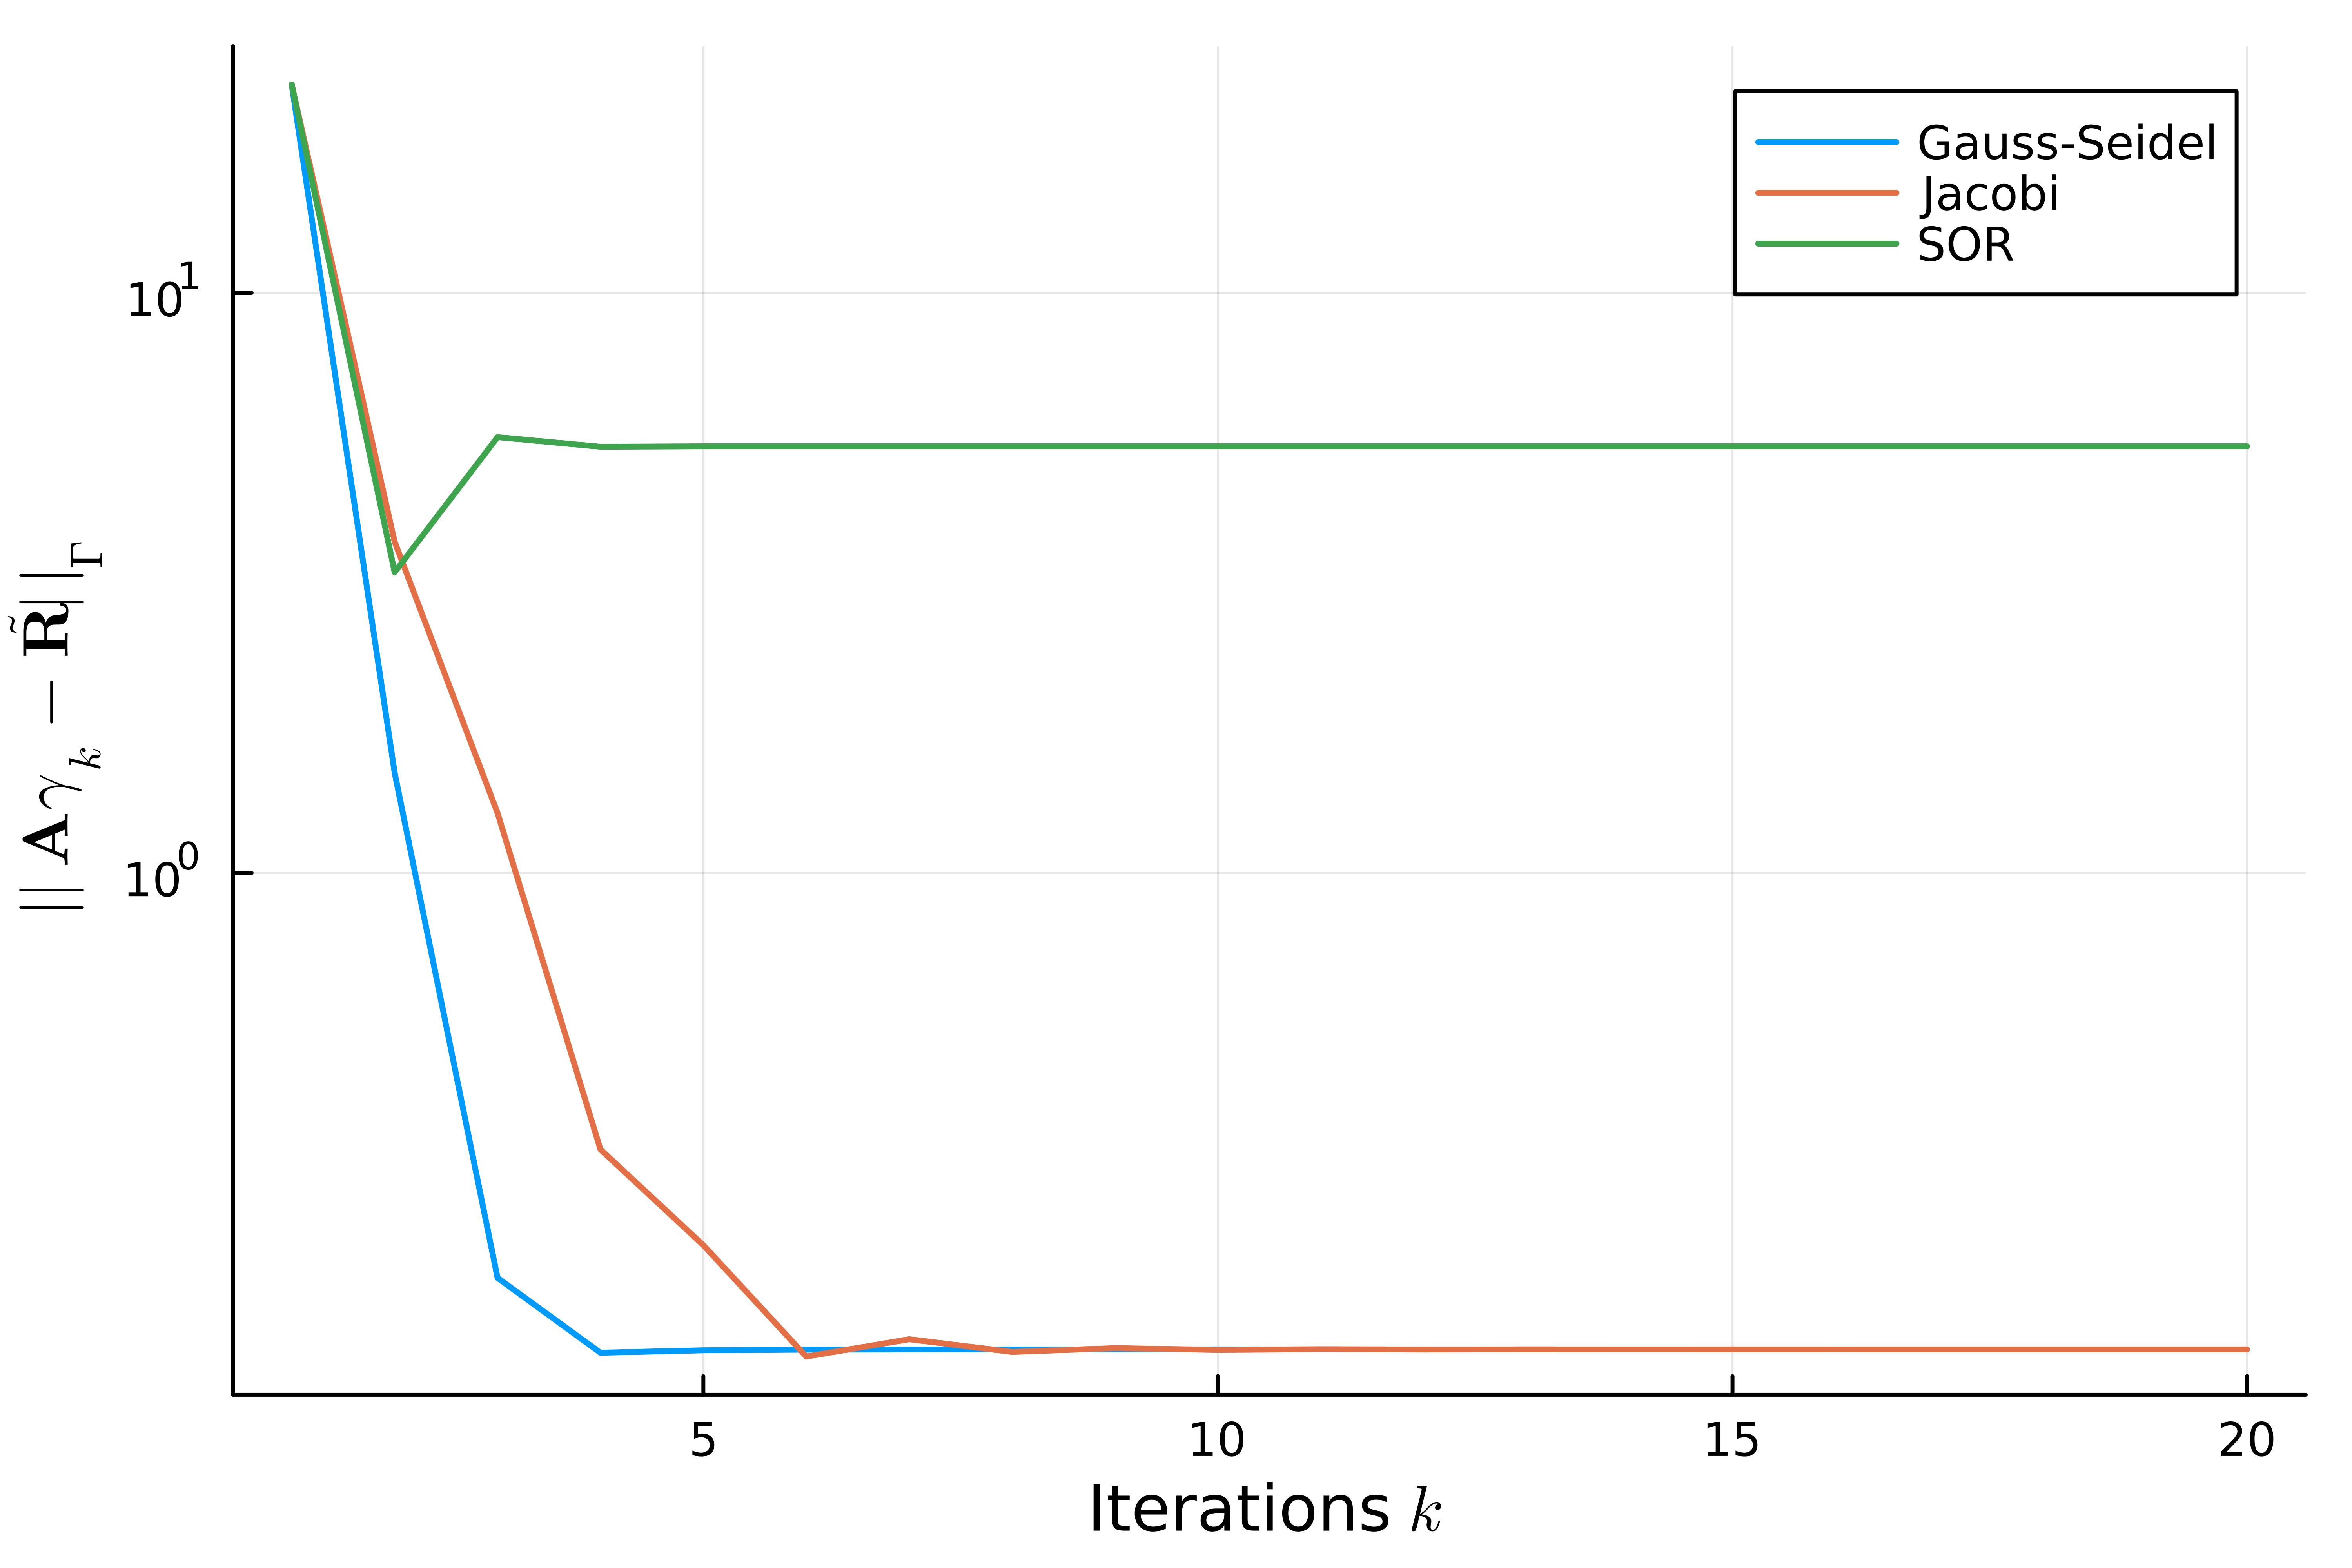

In [56]:
plot(1:iters, [perfG, perfJ, perfSOR], label=["Gauss-Seidel" "Jacobi" "SOR"], yscale=:log10, dpi=dpi, linewidth=l)
xlabel!("Iterations "*L"k")
ylabel!(L"||\mathbf{A}\gamma_k - \mathbf{\tilde{R}}||_{\Gamma}")
savefig(saveTo * "/residual-performance-2-agents.png")
display(Plots.current())

In [57]:
convJ = [diff(γj[i]) for i in 1:p.N];
convG = [diff(γg[i]) for i in 1:p.N];
convS = [diff(γsor[i]) for i in 1:p.N];
strongConvJ = [
	GammaNorm(
		[
			x -> kernelFunction(k₁, convJ[1][k], Y_train[1], x),
			x -> kernelFunction(k₂, convJ[2][k], Y_train[2], x),
		],
		Y_test,
		p = 2,
	) for k in 1:iters
];
strongConvG = [
	GammaNorm(
		[
			x -> kernelFunction(k₁, convG[1][k], Y_train[1], x),
			x -> kernelFunction(k₂, convG[2][k], Y_train[2], x),
		],
		Y_test,
		p = 2,
	) for k in 1:iters
];
strongConvSOR = [
	GammaNorm(
		[
			x -> kernelFunction(k₁, convS[1][k], Y_train[1], x),
			x -> kernelFunction(k₂, convS[2][k], Y_train[2], x),
		],
		Y_test,
		p = 2,
	) for k in 1:iters
];
kernelNormConvJ = [
	sum([kernelNorm(convJ[i][k], gramian(kernels[i], Y_train[i])) for i in 1:p.N]) for
	k in 1:iters
];
kernelNormConvG = [
	sum([kernelNorm(convG[i][k], gramian(kernels[i], Y_train[i])) for i in 1:p.N]) for
	k in 1:iters
];
kernelNormConvSOR = [
	sum([kernelNorm(convS[i][k], gramian(kernels[i], Y_train[i])) for i in 1:p.N]) for
	k in 1:iters
];


In [58]:
using Plots.PlotMeasures

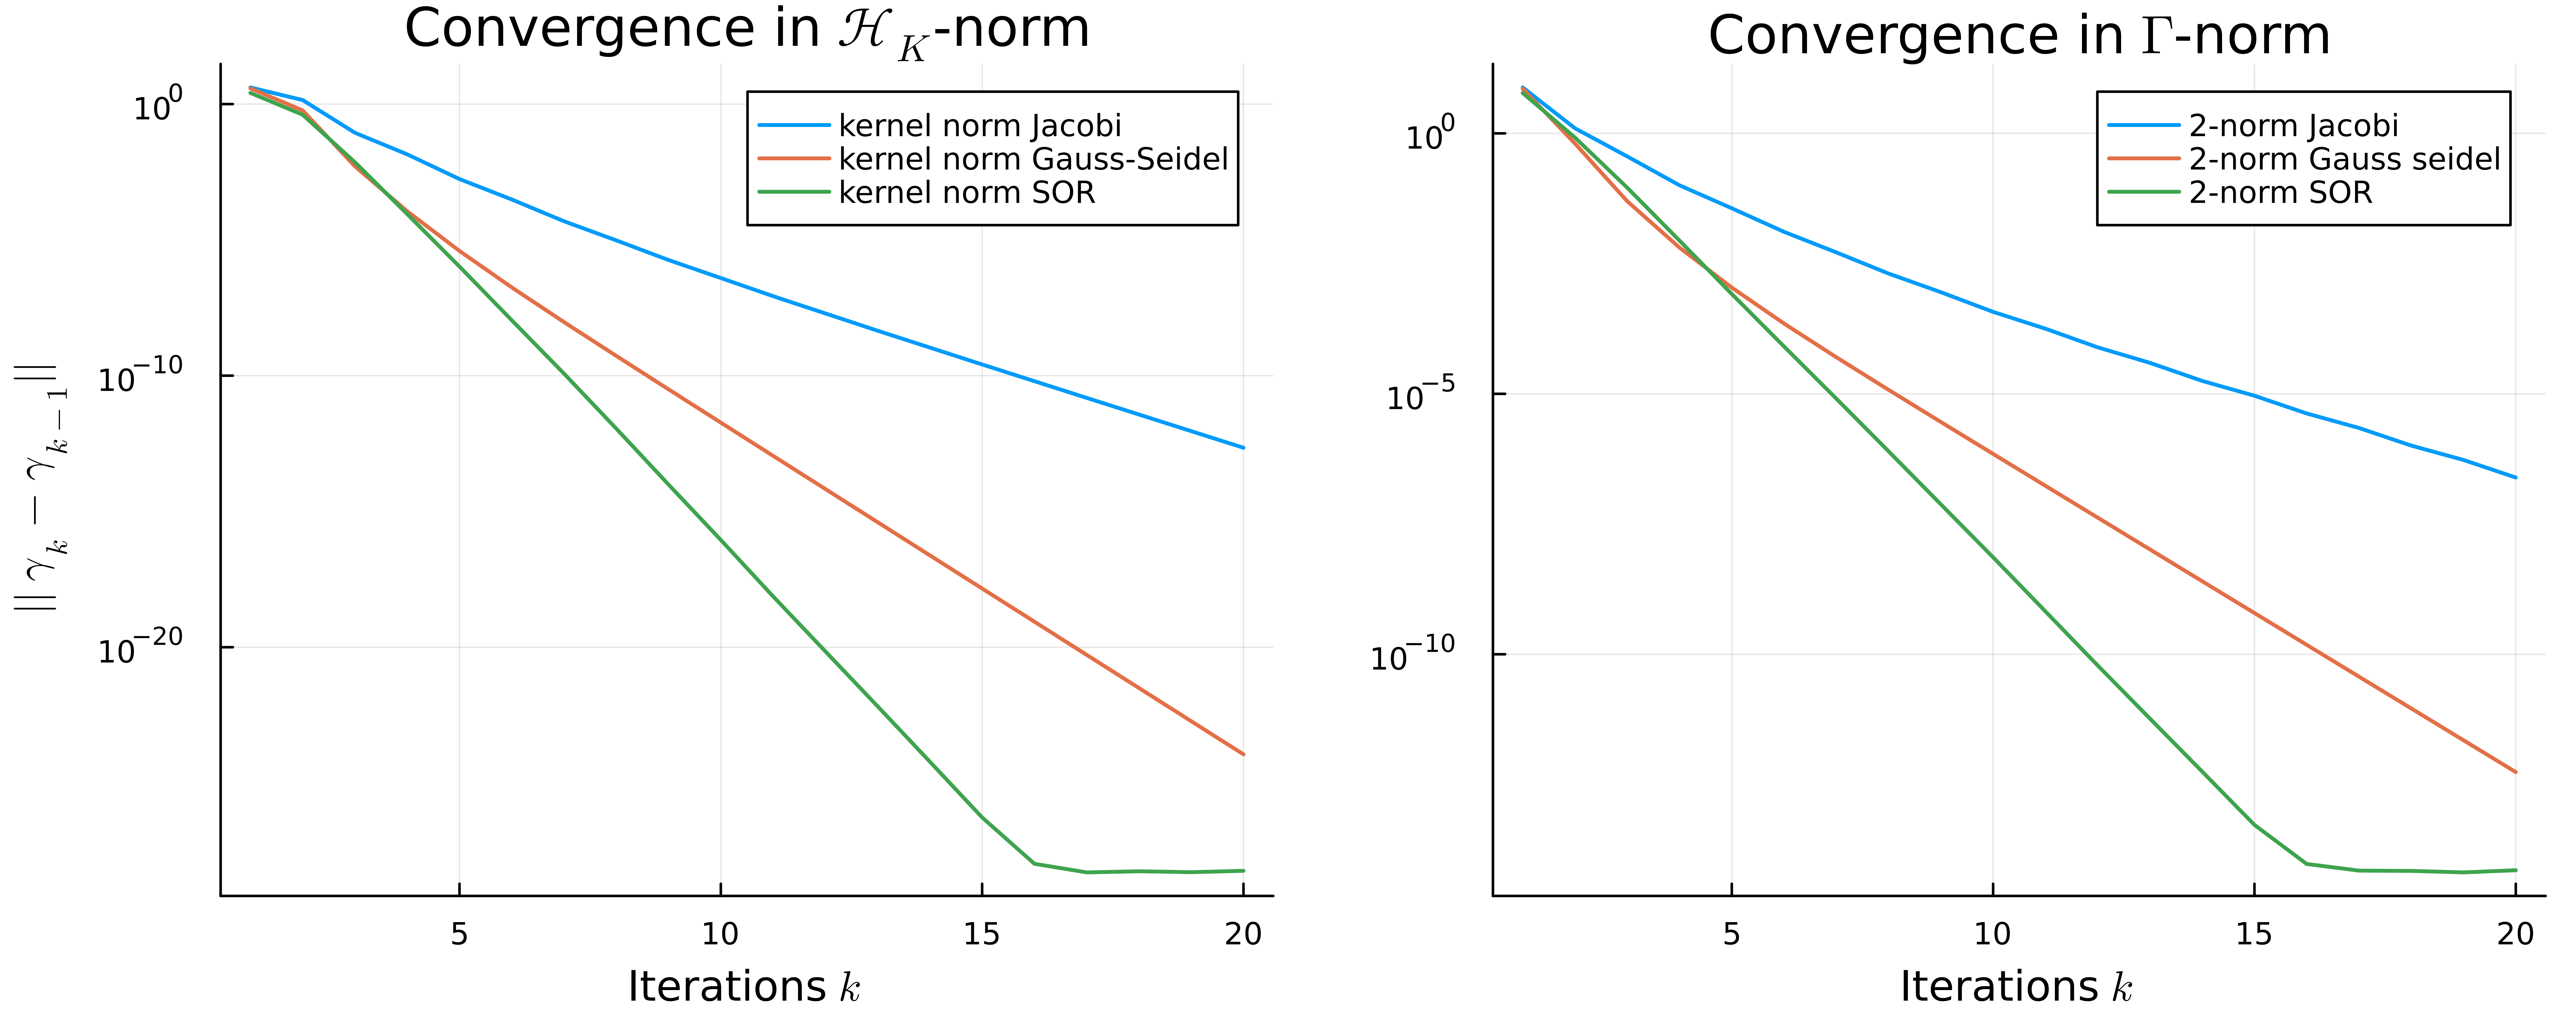

In [59]:
knorm = plot(
	1:iters,
	[kernelNormConvJ, kernelNormConvG, kernelNormConvSOR],
	label = ["kernel norm Jacobi" "kernel norm Gauss-Seidel" "kernel norm SOR"],
	yscale = :log10,
	dpi = dpi, linewidth = l, ylabel = L"||\gamma_k - \gamma_{k-1}||", title = "Convergence in " * L"\mathcal{H}_K" * "-norm"
)
l2norm = plot(
	1:iters,
	[strongConvJ, strongConvG, strongConvSOR],
	label = ["2-norm Jacobi" "2-norm Gauss seidel" "2-norm SOR"],
	yscale = :log10,
	dpi = dpi, linewidth = l, title = "Convergence in " * L"\Gamma" * "-norm"
)
plot(knorm, l2norm, size=(1000,400), left_margin=20px , bottom_margin=20px)
xlabel!("Iterations " * L"k")
savefig(saveTo * "/strong-convergence-performance-2-agents.png")
display(Plots.current())


In [60]:
costPerfJ = [cost(p,
	[
		x -> kernelFunction(k₁, γj[1][k], Y_train[1], x),
		x -> kernelFunction(k₂, γj[2][k], Y_train[2], x),
	], Y_test, Q_test, R_test, ones(Float64, m_test))
for k in 1:iters];
costPerfG = [cost(p,
	[
		x -> kernelFunction(k₁, γg[1][k], Y_train[1], x),
		x -> kernelFunction(k₂, γg[2][k], Y_train[2], x),
	], Y_test, Q_test, R_test, ones(Float64, m_test))
for k in 1:iters];
costPerfSOR = [cost(p,
	[
		x -> kernelFunction(k₁, γsor[1][k], Y_train[1], x),
		x -> kernelFunction(k₂, γsor[2][k], Y_train[2], x),
	], Y_test, Q_test, R_test, ones(Float64, m_test))
for k in 1:iters];

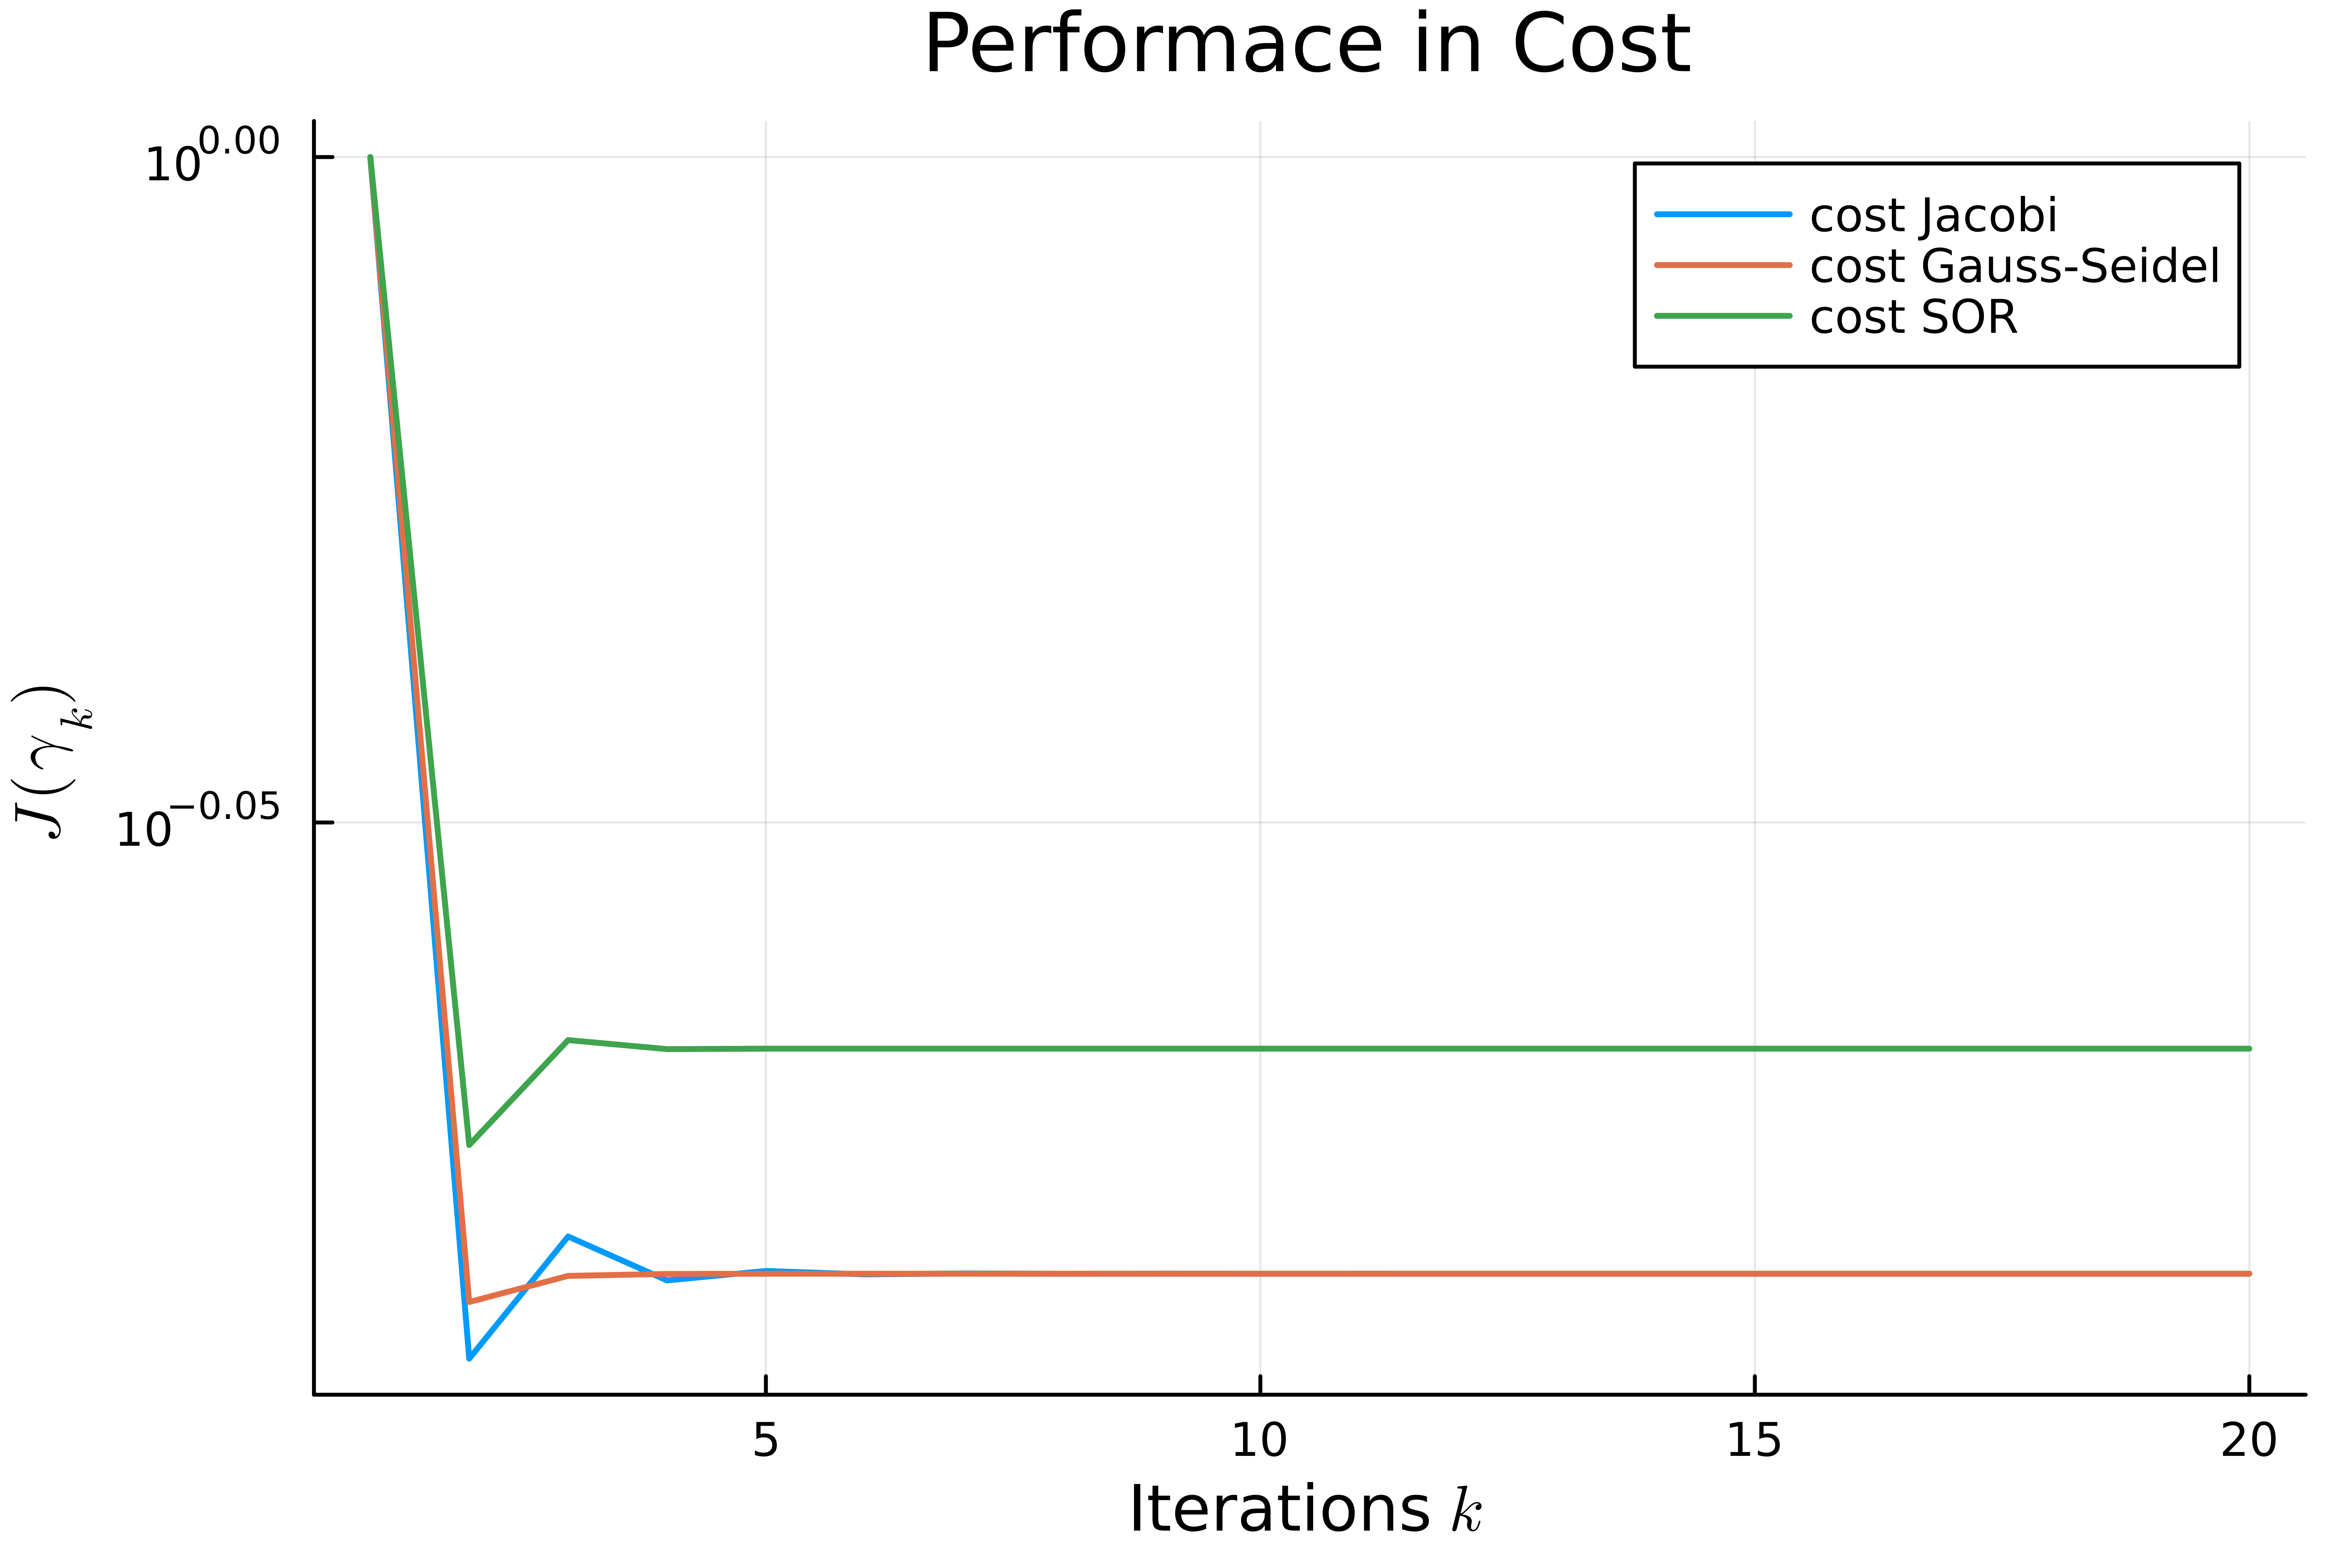

In [61]:
plot(1:iters, [costPerfJ, costPerfG, costPerfSOR], label=["cost Jacobi" "cost Gauss-Seidel" "cost SOR"], yscale=:log10,dpi=dpi, linewidth=l, title = "Performace in Cost")
xlabel!("Iterations " * L"k")
ylabel!(L"J(\gamma_k)")
savefig(saveTo * "/cost-performance-2-agents.png")
display(Plots.current())